In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
import os, codecs
%matplotlib inline
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn import metrics as skmetrics
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.manifold import TSNE
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

2017-08-22 23:31:03,160 : INFO : 'pattern' package found; tag filters are available for English
/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Dictionary features

In [2]:
personalities = pd.read_csv('~/personality-normalized-word2vec-norm.csv', encoding='utf-8')

In [3]:
personalities.shape

(1039, 186)

In [4]:
personalities = personalities.convert_objects(convert_numeric=True)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [5]:
liwc_attr = ['X1funct' ,'X2pronoun' ,'X3ppron','X4i','X5we','X6you','X7shehe','X8they','X9ipron','X10article','X11verb','X12auxverb','X13past','X14present','X15future','X16adverb','X17preps','X18conj','X19negate','X20quant','X21number','X22swear','X23social','X24family','X25friend','X26humans','X27affect','X28posemo','X29negemo','X30anx','X31anger','X32sad','X33cogmech','X34insight','X35cause','X36discrep','X37tentat','X38certain','X39inhib','X40incl','X41excl','X42percept','X43see','X44hear','X45feel','X46bio','X47body','X48health','X49sexual','X50ingest','X51relativ','X52motion','X53space','X54time','X55work','X56achieve','X57leisure','X58home','X59money','X60relig','X61death','X62assent','X63nonfl', 'X64filler']

In [6]:
attr = np.array(personalities[liwc_attr])
attr[np.isnan(attr)] = 0

In [7]:
personalities.extraversion_m.value_counts()

0    529
1    510
Name: extraversion_m, dtype: int64

In [8]:
train_data, test_data = train_test_split(personalities, test_size=0.3, random_state=42)

In [9]:
pre_proc_attr = ['skip', 'compound', 'hashtags', 'links', 'punct', 'questions', 'exclam', 'numbers', 'upcase', 'lowcase', 'firstup', 'pt.lexicon', 'added', 'verb.pro', 'names', 'en.lexicon', 'rewrite', 'mispell', 'foreign', 'laugh', 'emph', 'echars', 'unkn']

In [10]:
grammar_attr = ['m', 'f', 's', 'p', 'aument', 'dimin', 'superlat', 'N', 'A', 'PREP', 'CONJ', 'ADV', 'PREFIX', 'SIGLA', 'ABREV', 'INTERJ', 'DET', 'def', 'indef', 'NUM', 'numC', 'numO', 'numM', 'numF', 'PRO', 'proDem', 'proIndef', 'proRel', 'proInterr', 'proTrat', 'proPoss', 'proPess', 'acusativa', 'dativa', 'nominativa', 'obliqua', 'reflexa', 'p1', 'p2', 'p3', 'V', 'VW', 'VG', 'VK', 'VP', 'VI', 'VJ', 'VF', 'VQ', 'VS', 'VT', 'VU', 'VY', 'VC', 'V1s', 'V2s', 'V3s', 'V1p', 'V2p', 'V3p']

In [11]:
def scatter(x, colors, rrange):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in rrange:
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=3, foreground="w"),
            PathEffects.Normal()
            ])
        txts.append(txt)

    return f, ax, sc, txts

In [12]:
extraversion = personalities.extraversion.astype('int')

In [13]:
def remove_nan(atributes):
    train_attributes = np.array(train_data[atributes])
    test_attributes = np.array(test_data[atributes])
    train_attributes[np.isnan(train_attributes)] = 0
    test_attributes[np.isnan(test_attributes)] = 0
    return (train_attributes, test_attributes)

In [14]:
X = np.vstack([attr[extraversion==i]
               for i in range(1,6)])
y = np.hstack([personalities.extraversion.astype('int')[extraversion==i]
               for i in range(1,6)])

In [15]:
Xx = np.vstack([attr[personalities.extraversion_m==i]
               for i in range(0,2)])
yy = np.hstack([personalities.extraversion_m[personalities.extraversion_m==i]
               for i in range(0,2)])

In [16]:
five_class = TSNE(random_state=RS).fit_transform(X)

In [17]:
dual_class = TSNE(random_state=RS).fit_transform(Xx)

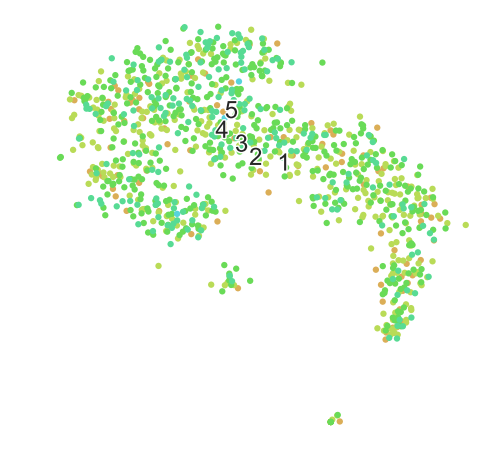

In [18]:
scatter(five_class, y, range(1,6))
plt.savefig('digits_tsne-generated.png', dpi=120)

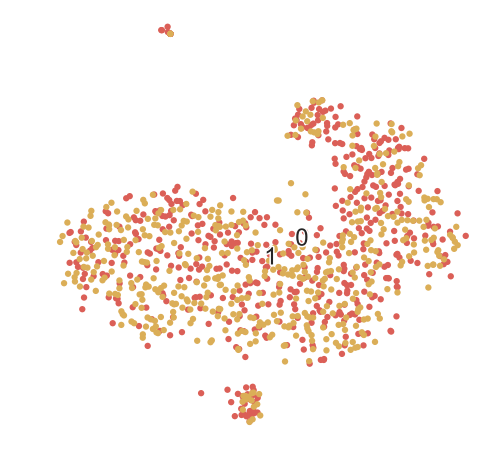

In [19]:
scatter(dual_class, yy, range(0,2))
plt.savefig('digits_tsne-generated.png', dpi=120)

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

force = False
model_trainer = RandomizedSearchCV(
    n_iter=1, 
    estimator=RandomForestClassifier(),
    param_distributions={
        "criterion": ["gini"],
        "n_estimators": [1000],
        "max_features": ["log2"],
        "max_depth": [None],
        "bootstrap": [True],
        "oob_score": [True],
        "class_weight": ["balanced"],
        "random_state": [42]
    },
    scoring="f1",
    verbose=True,
    refit=True,
    cv=10,
    n_jobs=-1
)

In [21]:
%%time
model_trainer.fit(train_data, train_data['extraversion_m'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib64/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/usr/lib/python2.7/site-packages/ipykernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/usr/lib64/python2.7/runpy.py in _run_code(code=<code object <module> at 0x7f42a62ae830, file "/...2.7/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/usr/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/usr/lib/python2.7/site-packages/ipykernel/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/usr/lib/python2.7/site-packages/ipykernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x7f42a62ae830, file "/...2.7/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/usr/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/usr/lib/python2.7/site-packages/ipykernel/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/usr/lib/python2.7/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/usr/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/lib64/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/usr/lib64/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/usr/lib64/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/usr/lib64/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/usr/lib64/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/usr/lib64/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/usr/lib64/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/usr/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"%%time\nmodel_trainer.fit(train_data, train_da...sion_m'])\nmodel = model_trainer.best_estimator_", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-08-22T23:31:14.698636', u'msg_id': u'24178EF58BD24F8488D61F2C803C509E', u'msg_type': u'execute_request', u'session': u'1FE1A1542BBA47E7832A3E7899F00FF5', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'24178EF58BD24F8488D61F2C803C509E', 'msg_type': u'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['1FE1A1542BBA47E7832A3E7899F00FF5']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u"%%time\nmodel_trainer.fit(train_data, train_da...sion_m'])\nmodel = model_trainer.best_estimator_", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-08-22T23:31:14.698636', u'msg_id': u'24178EF58BD24F8488D61F2C803C509E', u'msg_type': u'execute_request', u'session': u'1FE1A1542BBA47E7832A3E7899F00FF5', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'24178EF58BD24F8488D61F2C803C509E', 'msg_type': u'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/usr/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['1FE1A1542BBA47E7832A3E7899F00FF5'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"%%time\nmodel_trainer.fit(train_data, train_da...sion_m'])\nmodel = model_trainer.best_estimator_", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-08-22T23:31:14.698636', u'msg_id': u'24178EF58BD24F8488D61F2C803C509E', u'msg_type': u'execute_request', u'session': u'1FE1A1542BBA47E7832A3E7899F00FF5', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'24178EF58BD24F8488D61F2C803C509E', 'msg_type': u'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/usr/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u"%%time\nmodel_trainer.fit(train_data, train_da...sion_m'])\nmodel = model_trainer.best_estimator_", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u"%%time\nmodel_trainer.fit(train_data, train_da...sion_m'])\nmodel = model_trainer.best_estimator_"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/usr/lib/python2.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u"%%time\nmodel_trainer.fit(train_data, train_da...sion_m'])\nmodel = model_trainer.best_estimator_",), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u"%%time\nmodel_trainer.fit(train_data, train_da...sion_m'])\nmodel = model_trainer.best_estimator_",)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u"%%time\nmodel_trainer.fit(train_data, train_da...sion_m'])\nmodel = model_trainer.best_estimator_", store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-21-e1505bbae357>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 7f4255da1750, executi..._before_exec=None error_in_exec=None result=None>)
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])
   2826                 code = compiler(mod, cell_name, "single")
-> 2827                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f429c6f0730, file "<ipython-input-21-e1505bbae357>", line 1>
        result = <ExecutionResult object at 7f4255da1750, executi..._before_exec=None error_in_exec=None result=None>
   2828                     return True
   2829 
   2830             # Flush softspace
   2831             if softspace(sys.stdout, 0):

...........................................................................
/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f429c6f0730, file "<ipython-input-21-e1505bbae357>", line 1>, result=<ExecutionResult object at 7f4255da1750, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f429c6f0730, file "<ipython-input-21-e1505bbae357>", line 1>
        self.user_global_ns = {'BeautifulSoup': <class 'bs4.BeautifulSoup'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'In': ['', u'import logging\nlogging.root.handlers = []  # ...lib\nget_ipython().magic(u\'matplotlib inline\')', u"personalities = pd.read_csv('~/personality-normalized-word2vec-norm.csv', encoding='utf-8')", u'personalities.shape', u'personalities = personalities.convert_objects(convert_numeric=True)', u"liwc_attr = ['X1funct' ,'X2pronoun' ,'X3ppron'...,'X61death','X62assent','X63nonfl', 'X64filler']", u'attr = np.array(personalities[liwc_attr])\nattr[np.isnan(attr)] = 0', u'personalities.extraversion_m.value_counts()', u'train_data, test_data = train_test_split(personalities, test_size=0.3, random_state=42)', u"pre_proc_attr = ['skip', 'compound', 'hashtags...', 'foreign', 'laugh', 'emph', 'echars', 'unkn']", u"grammar_attr = ['m', 'f', 's', 'p', 'aument', ... 'VC', 'V1s', 'V2s', 'V3s', 'V1p', 'V2p', 'V3p']", u'def scatter(x, colors, rrange):\n    # We choo...  txts.append(txt)\n\n    return f, ax, sc, txts', u"extraversion = personalities.extraversion.astype('int')", u'def remove_nan(atributes):\n    train_attribut...\n    return (train_attributes, test_attributes)', u"X = np.vstack([attr[extraversion==i]\n        ...ersion==i]\n               for i in range(1,6)])", u'Xx = np.vstack([attr[personalities.extraversio...sion_m==i]\n               for i in range(0,2)])', u'five_class = TSNE(random_state=RS).fit_transform(X)', u'dual_class = TSNE(random_state=RS).fit_transform(Xx)', u"scatter(five_class, y, range(1,6))\nplt.savefig('digits_tsne-generated.png', dpi=120)", u"scatter(dual_class, yy, range(0,2))\nplt.savefig('digits_tsne-generated.png', dpi=120)", ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'Out': {3: (1039, 186), 7: 0    529
1    510
Name: extraversion_m, dtype: int64}, 'PathEffects': <module 'matplotlib.patheffects' from '/usr/lib6...hon2.7/site-packages/matplotlib/patheffects.pyc'>, 'RS': 20150101, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'TSNE': <class 'sklearn.manifold.t_sne.TSNE'>, ...}
        self.user_ns = {'BeautifulSoup': <class 'bs4.BeautifulSoup'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'In': ['', u'import logging\nlogging.root.handlers = []  # ...lib\nget_ipython().magic(u\'matplotlib inline\')', u"personalities = pd.read_csv('~/personality-normalized-word2vec-norm.csv', encoding='utf-8')", u'personalities.shape', u'personalities = personalities.convert_objects(convert_numeric=True)', u"liwc_attr = ['X1funct' ,'X2pronoun' ,'X3ppron'...,'X61death','X62assent','X63nonfl', 'X64filler']", u'attr = np.array(personalities[liwc_attr])\nattr[np.isnan(attr)] = 0', u'personalities.extraversion_m.value_counts()', u'train_data, test_data = train_test_split(personalities, test_size=0.3, random_state=42)', u"pre_proc_attr = ['skip', 'compound', 'hashtags...', 'foreign', 'laugh', 'emph', 'echars', 'unkn']", u"grammar_attr = ['m', 'f', 's', 'p', 'aument', ... 'VC', 'V1s', 'V2s', 'V3s', 'V1p', 'V2p', 'V3p']", u'def scatter(x, colors, rrange):\n    # We choo...  txts.append(txt)\n\n    return f, ax, sc, txts', u"extraversion = personalities.extraversion.astype('int')", u'def remove_nan(atributes):\n    train_attribut...\n    return (train_attributes, test_attributes)', u"X = np.vstack([attr[extraversion==i]\n        ...ersion==i]\n               for i in range(1,6)])", u'Xx = np.vstack([attr[personalities.extraversio...sion_m==i]\n               for i in range(0,2)])', u'five_class = TSNE(random_state=RS).fit_transform(X)', u'dual_class = TSNE(random_state=RS).fit_transform(Xx)', u"scatter(five_class, y, range(1,6))\nplt.savefig('digits_tsne-generated.png', dpi=120)", u"scatter(dual_class, yy, range(0,2))\nplt.savefig('digits_tsne-generated.png', dpi=120)", ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'Out': {3: (1039, 186), 7: 0    529
1    510
Name: extraversion_m, dtype: int64}, 'PathEffects': <module 'matplotlib.patheffects' from '/usr/lib6...hon2.7/site-packages/matplotlib/patheffects.pyc'>, 'RS': 20150101, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'TSNE': <class 'sklearn.manifold.t_sne.TSNE'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/home/bahbbc/workspace/masters-big5/liwc/<ipython-input-21-e1505bbae357> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 get_ipython().run_cell_magic(u'time', u'', u"model_trainer.fit(train_data, train_data['extraversion_m'])\nmodel = model_trainer.best_estimator_")
      7 
      8 
      9 
     10 

...........................................................................
/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name=u'time', line=u'', cell=u"model_trainer.fit(train_data, train_data['extr...sion_m'])\nmodel = model_trainer.best_estimator_")
   2110             # This will need to be updated if the internal calling logic gets
   2111             # refactored, or else we'll be expanding the wrong variables.
   2112             stack_depth = 2
   2113             magic_arg_s = self.var_expand(line, stack_depth)
   2114             with self.builtin_trap:
-> 2115                 result = fn(magic_arg_s, cell)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        magic_arg_s = u''
        cell = u"model_trainer.fit(train_data, train_data['extr...sion_m'])\nmodel = model_trainer.best_estimator_"
   2116             return result
   2117 
   2118     def find_line_magic(self, magic_name):
   2119         """Find and return a line magic by name.

...........................................................................
/home/bahbbc/workspace/masters-big5/liwc/<decorator-gen-59> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line=u'', cell=u"model_trainer.fit(train_data, train_data['extr...sion_m'])\nmodel = model_trainer.best_estimator_", local_ns=None)
      1 
----> 2 
      3 
      4 
      5 
      6 
      7 
      8 
      9 
     10 

...........................................................................
/usr/lib/python2.7/site-packages/IPython/core/magic.py in <lambda>(f=<function time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, u'', u"model_trainer.fit(train_data, train_data['extr...sion_m'])\nmodel = model_trainer.best_estimator_", None), **k={})
    183     validate_type(magic_kind)
    184 
    185     # This is a closure to capture the magic_kind.  We could also use a class,
    186     # but it's overkill for just that one bit of state.
    187     def magic_deco(arg):
--> 188         call = lambda f, *a, **k: f(*a, **k)
        f = <function time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, u'', u"model_trainer.fit(train_data, train_data['extr...sion_m'])\nmodel = model_trainer.best_estimator_", None)
        k = {}
    189 
    190         if callable(arg):
    191             # "Naked" decorator call (just @foo, no args)
    192             func = arg

...........................................................................
/usr/lib/python2.7/site-packages/IPython/core/magics/execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line=u'', cell=u"model_trainer.fit(train_data, train_data['extr...sion_m'])\nmodel = model_trainer.best_estimator_", local_ns=None)
   1175             st = clock2()
   1176             out = eval(code, glob, local_ns)
   1177             end = clock2()
   1178         else:
   1179             st = clock2()
-> 1180             exec(code, glob, local_ns)
        code = <code object <module> at 0x7f4255a4d8b0, file "<timed exec>", line 1>
        glob = {'BeautifulSoup': <class 'bs4.BeautifulSoup'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'In': ['', u'import logging\nlogging.root.handlers = []  # ...lib\nget_ipython().magic(u\'matplotlib inline\')', u"personalities = pd.read_csv('~/personality-normalized-word2vec-norm.csv', encoding='utf-8')", u'personalities.shape', u'personalities = personalities.convert_objects(convert_numeric=True)', u"liwc_attr = ['X1funct' ,'X2pronoun' ,'X3ppron'...,'X61death','X62assent','X63nonfl', 'X64filler']", u'attr = np.array(personalities[liwc_attr])\nattr[np.isnan(attr)] = 0', u'personalities.extraversion_m.value_counts()', u'train_data, test_data = train_test_split(personalities, test_size=0.3, random_state=42)', u"pre_proc_attr = ['skip', 'compound', 'hashtags...', 'foreign', 'laugh', 'emph', 'echars', 'unkn']", u"grammar_attr = ['m', 'f', 's', 'p', 'aument', ... 'VC', 'V1s', 'V2s', 'V3s', 'V1p', 'V2p', 'V3p']", u'def scatter(x, colors, rrange):\n    # We choo...  txts.append(txt)\n\n    return f, ax, sc, txts', u"extraversion = personalities.extraversion.astype('int')", u'def remove_nan(atributes):\n    train_attribut...\n    return (train_attributes, test_attributes)', u"X = np.vstack([attr[extraversion==i]\n        ...ersion==i]\n               for i in range(1,6)])", u'Xx = np.vstack([attr[personalities.extraversio...sion_m==i]\n               for i in range(0,2)])', u'five_class = TSNE(random_state=RS).fit_transform(X)', u'dual_class = TSNE(random_state=RS).fit_transform(Xx)', u"scatter(five_class, y, range(1,6))\nplt.savefig('digits_tsne-generated.png', dpi=120)", u"scatter(dual_class, yy, range(0,2))\nplt.savefig('digits_tsne-generated.png', dpi=120)", ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'Out': {3: (1039, 186), 7: 0    529
1    510
Name: extraversion_m, dtype: int64}, 'PathEffects': <module 'matplotlib.patheffects' from '/usr/lib6...hon2.7/site-packages/matplotlib/patheffects.pyc'>, 'RS': 20150101, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'TSNE': <class 'sklearn.manifold.t_sne.TSNE'>, ...}
        local_ns = None
   1181             end = clock2()
   1182             out = None
   1183         wall_end = wtime()
   1184         # Compute actual times and report

...........................................................................
/home/bahbbc/workspace/masters-big5/liwc/<timed exec> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 
      7 
      8 
      9 
     10 

...........................................................................
/usr/lib64/python2.7/site-packages/sklearn/model_selection/_search.py in fit(self=RandomizedSearchCV(cv=10, error_score='raise',
 ...urn_train_score=True, scoring='f1', verbose=True), X=     Unnamed: 0  file_name                      ...   1                0  

[727 rows x 186 columns], y=118    1
914    0
250    0
390    1
827    0
377...    1
860    0
Name: extraversion_m, dtype: int64, groups=None)
   1185             train/test set.
   1186         """
   1187         sampled_params = ParameterSampler(self.param_distributions,
   1188                                           self.n_iter,
   1189                                           random_state=self.random_state)
-> 1190         return self._fit(X, y, groups, sampled_params)
        self._fit = <bound method RandomizedSearchCV._fit of Randomi...rn_train_score=True, scoring='f1', verbose=True)>
        X =      Unnamed: 0  file_name                      ...   1                0  

[727 rows x 186 columns]
        y = 118    1
914    0
250    0
390    1
827    0
377...    1
860    0
Name: extraversion_m, dtype: int64
        groups = None
        sampled_params = <sklearn.model_selection._search.ParameterSampler object>
   1191 
   1192 
   1193 
   1194 

...........................................................................
/usr/lib64/python2.7/site-packages/sklearn/model_selection/_search.py in _fit(self=RandomizedSearchCV(cv=10, error_score='raise',
 ...urn_train_score=True, scoring='f1', verbose=True), X=     Unnamed: 0  file_name                      ...   1                0  

[727 rows x 186 columns], y=118    1
914    0
250    0
390    1
827    0
377...    1
860    0
Name: extraversion_m, dtype: int64, groups=None, parameter_iterable=<sklearn.model_selection._search.ParameterSampler object>)
    559                                   fit_params=self.fit_params,
    560                                   return_train_score=self.return_train_score,
    561                                   return_n_test_samples=True,
    562                                   return_times=True, return_parameters=True,
    563                                   error_score=self.error_score)
--> 564           for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.model_selection._search.ParameterSampler object>
    565           for train, test in cv_iter)
    566 
    567         # if one choose to see train score, "out" will contain train score info
    568         if self.return_train_score:

...........................................................................
/usr/lib64/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Tue Aug 22 23:31:15 2017
PID: 13404                                   Python 2.7.13: /usr/bin/python
...........................................................................
/usr/lib64/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=42, verbose=0, warm_start=False),      Unnamed: 0  file_name                      ...   1                0  

[727 rows x 186 columns], 118    1
914    0
250    0
390    1
827    0
377...    1
860    0
Name: extraversion_m, dtype: int64, make_scorer(f1_score), array([ 62,  64,  65,  66,  68,  69,  71,  74,  ..., 719, 720, 721, 722,
       723, 724, 725, 726]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 67, 70, 72, 73, 75,
       76, 78, 80, 82, 85]), True, {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 1000, 'oob_score': True, 'random_state': 42})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True}
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=42, verbose=0, warm_start=False),      Unnamed: 0  file_name                      ...   1                0  

[727 rows x 186 columns], 118    1
914    0
250    0
390    1
827    0
377...    1
860    0
Name: extraversion_m, dtype: int64, make_scorer(f1_score), array([ 62,  64,  65,  66,  68,  69,  71,  74,  ..., 719, 720, 721, 722,
       723, 724, 725, 726]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 67, 70, 72, 73, 75,
       76, 78, 80, 82, 85]), True, {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 1000, 'oob_score': True, 'random_state': 42}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/lib64/python2.7/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=42, verbose=0, warm_start=False), X=     Unnamed: 0  file_name                      ...   1                0  

[727 rows x 186 columns], y=118    1
914    0
250    0
390    1
827    0
377...    1
860    0
Name: extraversion_m, dtype: int64, scorer=make_scorer(f1_score), train=array([ 62,  64,  65,  66,  68,  69,  71,  74,  ..., 719, 720, 721, 722,
       723, 724, 725, 726]), test=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 67, 70, 72, 73, 75,
       76, 78, 80, 82, 85]), verbose=True, parameters={'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 1000, 'oob_score': True, 'random_state': 42}, fit_params={}, return_train_score=True, return_parameters=True, return_n_test_samples=True, return_times=True, error_score='raise')
    233 
    234     try:
    235         if y_train is None:
    236             estimator.fit(X_train, **fit_params)
    237         else:
--> 238             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method RandomForestClassifier.fit of Rand...e, random_state=42, verbose=0, warm_start=False)>
        X_train =       Unnamed: 0  file_name  \
969          970 ...   1                0  

[654 rows x 186 columns]
        y_train = 969     1
585     1
311     1
849     1
551     ...   1
860     0
Name: extraversion_m, dtype: int64
        fit_params = {}
    239 
    240     except Exception as e:
    241         # Note fit time as time until error
    242         fit_time = time.time() - start_time

...........................................................................
/usr/lib64/python2.7/site-packages/sklearn/ensemble/forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=42, verbose=0, warm_start=False), X=      Unnamed: 0  file_name  \
969          970 ...   1                0  

[654 rows x 186 columns], y=969     1
585     1
311     1
849     1
551     ...   1
860     0
Name: extraversion_m, dtype: int64, sample_weight=None)
    242         -------
    243         self : object
    244             Returns self.
    245         """
    246         # Validate or convert input data
--> 247         X = check_array(X, accept_sparse="csc", dtype=DTYPE)
        X =       Unnamed: 0  file_name  \
969          970 ...   1                0  

[654 rows x 186 columns]
    248         y = check_array(y, accept_sparse='csc', ensure_2d=False, dtype=None)
    249         if issparse(X):
    250             # Pre-sort indices to avoid that each individual tree of the
    251             # ensemble sorts the indices.

...........................................................................
/usr/lib64/python2.7/site-packages/sklearn/utils/validation.py in check_array(array=      Unnamed: 0  file_name  \
969          970 ...   1                0  

[654 rows x 186 columns], accept_sparse=['csc'], dtype=<type 'numpy.float32'>, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    377 
    378     if sp.issparse(array):
    379         array = _ensure_sparse_format(array, accept_sparse, dtype, copy,
    380                                       force_all_finite)
    381     else:
--> 382         array = np.array(array, dtype=dtype, order=order, copy=copy)
        array =       Unnamed: 0  file_name  \
969          970 ...   1                0  

[654 rows x 186 columns]
        dtype = <type 'numpy.float32'>
        order = None
        copy = False
    383 
    384         if ensure_2d:
    385             if array.ndim == 1:
    386                 if ensure_min_samples >= 2:

ValueError: could not convert string to float: no 
___________________________________________________________________________

In [ ]:
print train.shape
print train_data['extraversion_m'].shape

In [ ]:
yp = model.predict(test_data)
yt = test_data['extraversion_m']

In [ ]:
pd.DataFrame(
    index=pd.Index([0, 1], name="y_true"),
    columns=pd.Index([0, 1], name="y_pred"),
    data=skmetrics.confusion_matrix(y_true=yt, y_pred=yp)
)

In [ ]:
print skmetrics.classification_report(y_true=yt, y_pred=yp)

In [ ]:
accuracy_score(yt, yp)